In [2]:
import re
import numpy
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


def parse_training_log(file):
    log_data = {
        'epoch': [],
        'type': [],
        'metric': [],
        'value': []
    }

    for line in file:
        if "Training epoch" in line:
            epoch = int(re.search(r"epoch (\d+)", line).group(1))
        elif "Epoch" in line and "on test dataset" in line:
            test_data = re.search(
                r"Epoch \d+ on test dataset: MRR: ([0-9.]+); Recalls: tensor\(\[([0-9., ]+)\]\) Loss: ([0-9.]+)positive-loss: ([0-9.]+); negative-loss: ([0-9.]+)",
                line)
            if test_data:
                mrr, recalls, loss, pos_loss, neg_loss = test_data.groups()
                recalls = recalls.split(', ')
                log_data['epoch'].extend([epoch] * 7)
                log_data['type'].extend(['test'] * 7)
                log_data['metric'].extend(['MRR', 'Recall@1', 'Recall@5', 'Recall@10',
                                           'Total Loss', 'Positive Loss', 'Negative Loss'])
                log_data['value'].extend(
                    [float(mrr), float(recalls[0]), float(recalls[1]), float(recalls[2]), float(loss), 
                     float(pos_loss), float(neg_loss)])
        elif "Training batch" in line:
            batch_data = re.search(r"Training batch (\d+)/\d+ loss: ([0-9.]+)", line)
            if batch_data:
                batch, loss = batch_data.groups()
                log_data['epoch'].append(epoch)
                log_data['type'].append('batch')
                log_data['metric'].append(f'Batch {batch} loss')
                log_data['value'].append(float(loss))
        elif "Epoch" in line and "on training dataset" in line:
            train_data = re.search(
                r"Epoch \d+ on training dataset: loss: ([0-9.]+); positive-loss: ([0-9.]+); negative-loss: ([0-9.]+)",
                line)
            if train_data:
                total_loss, pos_loss, neg_loss = train_data.groups()
                log_data['epoch'].extend([epoch] * 3)
                log_data['type'].extend(['train'] * 3)
                log_data['metric'].extend(['Total Loss', 'Positive Loss', 'Negative Loss'])
                log_data['value'].extend([float(total_loss), float(pos_loss), float(neg_loss)])

    return pd.DataFrame(log_data)


# Example usage:
with open('../logs/log_2024-06-03_19-36-01_dr01.log', 'r') as f:
    df_dr01 = parse_training_log(f)
    
with open('../logs/log_2024-06-03_19-36-00_dr02.log', 'r') as f:
    df_dr02 = parse_training_log(f)

df_dr01['dropout'] = 0.1
df_dr02['dropout'] = 0.2
df_dropouts = pd.concat([df_dr01, df_dr02])
df_dropouts


,epoch,type,metric,value,dropout
0,0,test,MRR,0.080000,0.1
1,0,test,Recall@1,0.009100,0.1
2,0,test,Recall@5,0.081400,0.1
3,0,test,Recall@10,0.179700,0.1
4,0,test,Total Loss,24180.260000,0.1
...,...,...,...,...,...
745,29,batch,Batch 6500 loss,0.234612,0.2
746,29,batch,Batch 7000 loss,0.018001,0.2
747,29,train,Total Loss,4017.681875,0.2
748,29,train,Positive Loss,3539.870000,0.2


/mnt/data/xjarol06_firllm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/data/xjarol06_firllm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


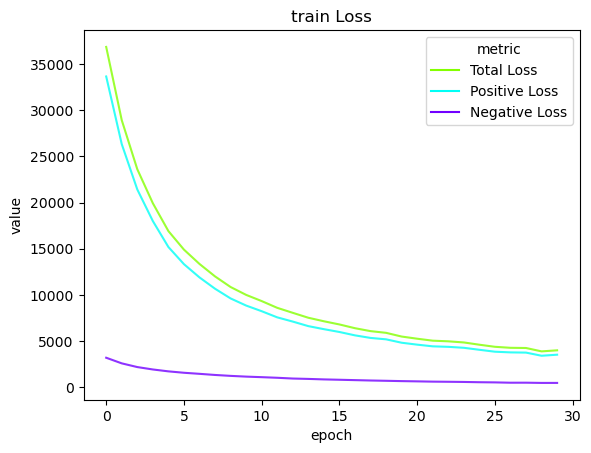

/mnt/data/xjarol06_firllm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mnt/data/xjarol06_firllm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


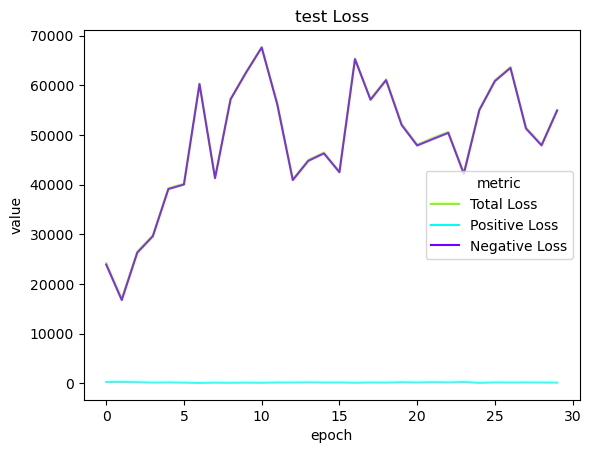

In [4]:
def plot_losses(df):
    def plot_one(df, type):
        df_train = df[df['type'] == type]
        df_train_loss = df_train[df_train['metric'].apply(lambda x: 'loss' in x.lower())]
        ax = sns.lineplot(data=df_train_loss, x='epoch', y='value', hue='metric',
                          alpha=0.8,
                          palette=sns.color_palette("hsv", 3))
        
        ax.title.set_text(f'{type} Loss')
        plt.show()
    for type in ['train', 'test']:
        plot_one(df, type)
        

plot_losses(df_dr01)

,epoch,type,metric,value,dropout
579,23,test,Total Loss,73358.09,0.2


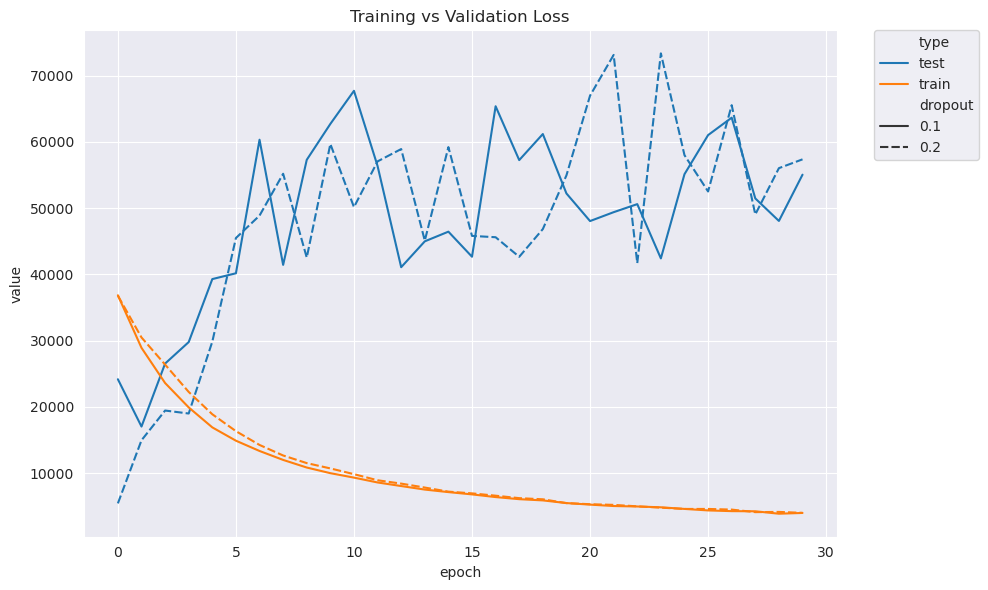

In [105]:
# training vs validation loss

def plot_loss(df, style):
    fix, ax = plt.subplots(figsize=(10, 6))
    
    df_train_loss = df[df['metric'].apply(lambda x: 'Total Loss' in x)]
    df_train_loss = df_train_loss[df_train_loss['type'].apply(lambda x: not 'batch' in x)]
    ax = sns.lineplot(data=df_train_loss, x='epoch', y='value', hue='type', style=style, errorbar=None, ax=ax)
        
    ax.title.set_text('Training vs Validation Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout() 
    return df_train_loss
    
df = plot_loss(df_dropouts, 'dropout')
# get highest loss
df[df['value'] == df['value'].max()]

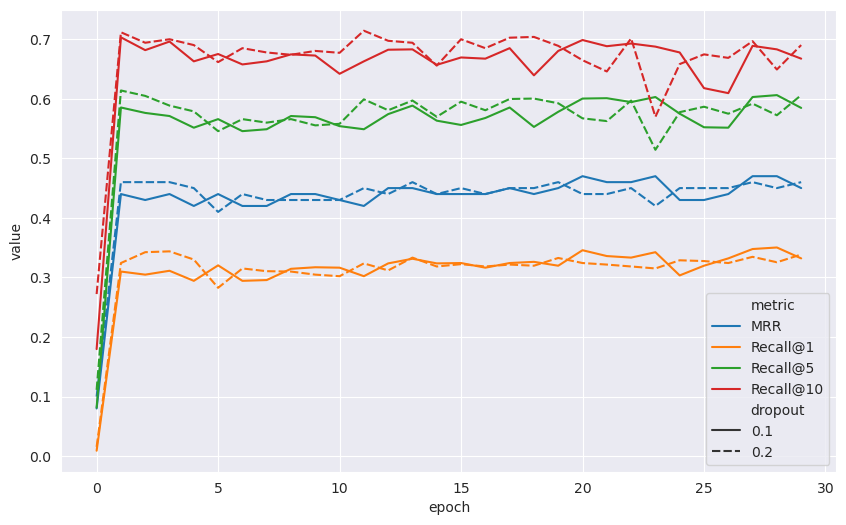

In [129]:
def plot_results(df, style):
    fix, ax = plt.subplots(figsize=(10, 6))
    df_test_mrr = df[(df['metric'] == 'MRR') | (df['metric'].apply(lambda x: 'Recall' in x))]
    # ax = sns.lineplot(data=df_test_mrr, x='epoch', y='value', hue='metric')  # Without dropout style
    ax = sns.lineplot(data=df_test_mrr, x='epoch', y='value', hue='metric', style=style, ax=ax)

plot_results(df_dropouts, 'dropout')

# Gradient Clipping

In [126]:

df_dr01_e8 = df_dr01[df_dr01['epoch'] <= 8].copy()

with open('../logs/log_2024-06-03_23-47-58_gc1.log', 'r') as f:
    df_gc1 = parse_training_log(f)
    
with open('../logs/log_2024-06-03_23-41-12_gc3.log', 'r') as f:
    df_gc3 = parse_training_log(f)
    
with open('../logs/log_2024-06-03_23-51-22_gc5.log', 'r') as f:
    df_gc5 = parse_training_log(f)

df_gc1['grad_clip'] = 1
df_gc3['grad_clip'] = 3
df_gc5['grad_clip'] = 5
df_dr01_e8['grad_clip'] = 0
df_grad_clips = pd.concat([df_gc1, df_gc3, df_gc5, df_dr01_e8])

,epoch,type,metric,value,grad_clip,dropout
4,0,test,Total Loss,5049.600000,1,NaN
22,0,train,Total Loss,44410.779150,1,NaN
29,1,test,Total Loss,11199.620000,1,NaN
47,1,train,Total Loss,40385.941401,1,NaN
54,2,test,Total Loss,15241.800000,1,NaN
...,...,...,...,...,...,...
172,6,train,Total Loss,13354.826740,0,0.1
179,7,test,Total Loss,41438.070000,0,0.1
197,7,train,Total Loss,12005.627499,0,0.1
204,8,test,Total Loss,57290.620000,0,0.1


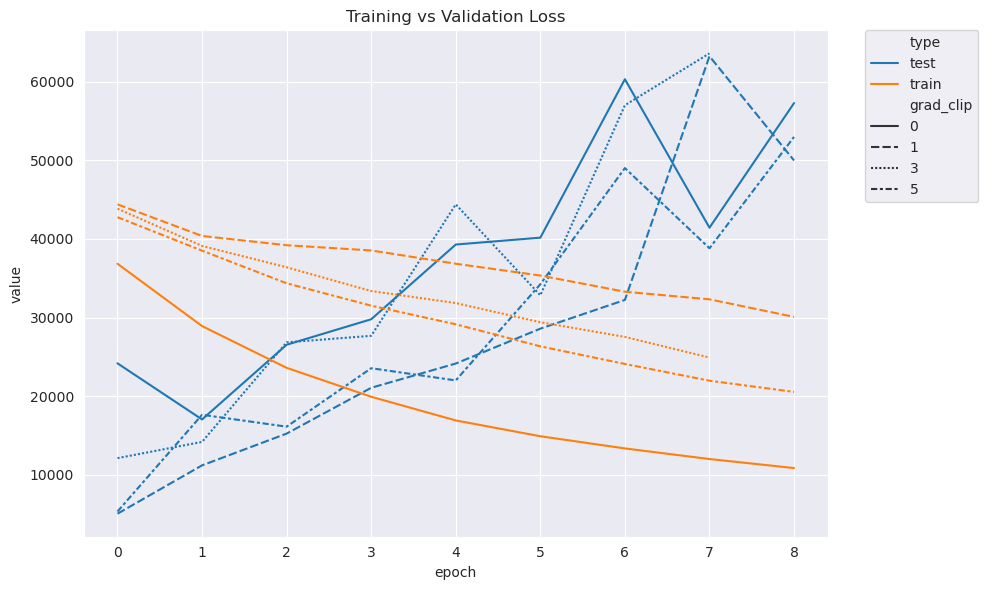

In [127]:
plot_loss(df_grad_clips, 'grad_clip')

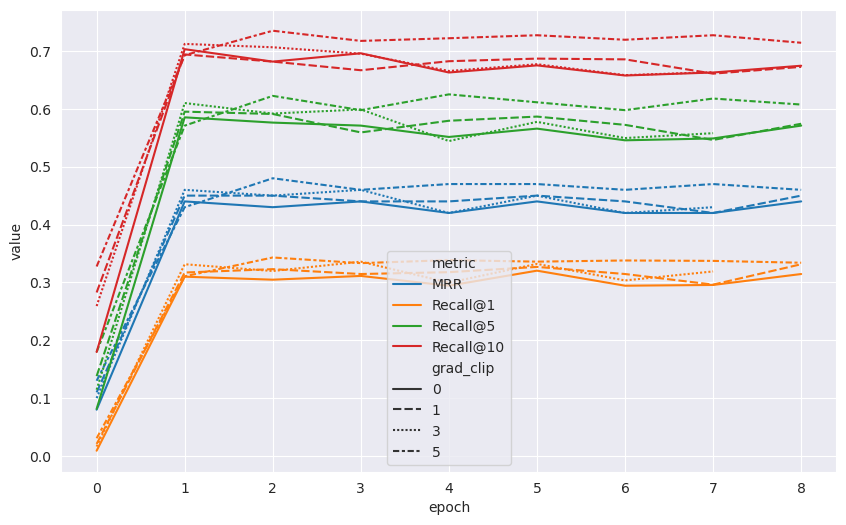

In [130]:
plot_results(df_grad_clips, 'grad_clip')

# Label Smoothing

/tmp/ipykernel_53464/2250474135.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


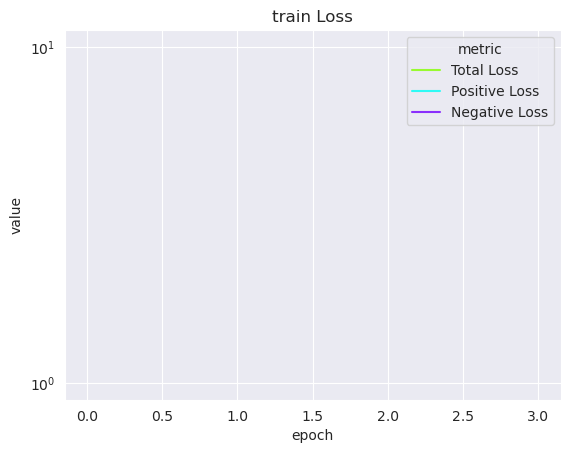

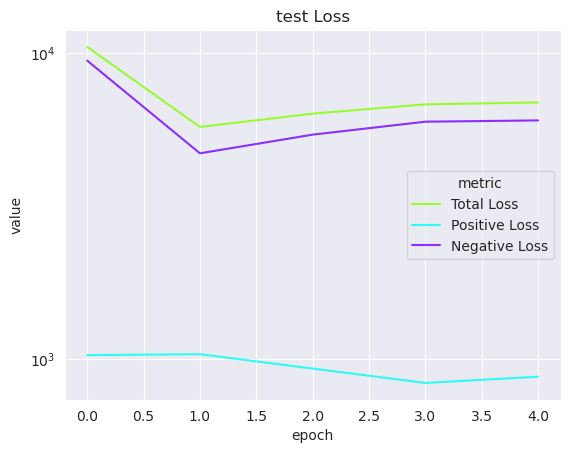

In [110]:
with open('../logs/log_2024-06-03_21-22-42_ls01_cpu.log', 'r') as f:
    df_ls_cpu = parse_training_log(f)

plot_losses(df_ls_cpu)

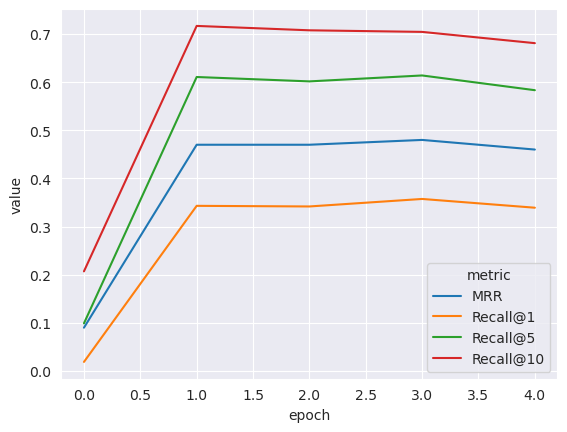

In [111]:
plot_results(df_ls_cpu, None)